In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import glob

import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Task 1

In [2]:
def remove_characters(text: str) -> str:
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def get_text_files(path: str, N=0, shuffle=False) -> list:
    text_files = glob.glob(f"{path}/*.txt")
    if shuffle:
        random.shuffle(text_files)
    if N == 0:
        N = len(text_files)
    text_files = text_files[:N]
    return text_files

def get_text(text_files: list) -> list:
    text = []
    for text_file in text_files:
        with open(text_file, 'r', errors='ignore') as f:
            content = remove_characters(f.read())
            content = content.lower()
            text.append(content)
    return text

def tokenization(text):
    if type(text) == list:
        return [word_tokenize(t) for t in text]
    elif type(text) == str:
        return word_tokenize(text)
    return None

In [3]:
# Obtain raw data of N documents and tokenize
N = 15
directory = "./nasa"
text_files = get_text_files(directory, N=N, shuffle=False)
text = get_text(text_files)
tokenized_text = tokenization(text)
print(tokenized_text)

[['miniature', 'electronic', 'temperature', 'controller', 'a', 'miniature', 'electronic', 'temperature', 'controller', 'was', 'developed', 'at', 'nasa', 'langley', 'research', 'center', 'to', 'provide', 'a', 'constant', 'temperature', 'environment', 'for', 'transducers', 'and', 'electronics', 'in', 'the', 'flaps', 'and', 'slats', 'of', 'a', 'boeing', 'aircraft', 'new', 'packaging', 'technology', 'has', 'allowed', 'nasa', 'langley', 'to', 'build', 'a', 'miniature', 'controller', 'that', 'can', 'be', 'mounted', 'almost', 'anywhere', 'the', 'controller', 'also', 'provides', 'a', 'temperature', 'monitor', 'signal', 'allowing', 'the', 'user', 'to', 'verify', 'the', 'equipment', 'is', 'controlled', 'at', 'the', 'selected', 'temperature', 'miniature', 'electronic', 'temperature', 'controller', 'controller', 'installed', 'on', 'pressure', 'array', 'system', 'potential', 'commercial', 'uses', 'temperature', 'sensitive', 'electronics', 'and', 'transducers', 'limited', 'volume', 'applications', '

## Task 2

In [4]:
def stemmer(tokenized_text: list):
    ps = PorterStemmer()
    stemmed_text = []
    for doc in tokenized_text:
        stemmed_text.append([ps.stem(token) for token in doc])

    stemmed_dict = {}
    for doc in stemmed_text:
        for token in doc:
            if token in stemmed_dict:
                stemmed_dict[token] += 1
            else:
                stemmed_dict[token] = 1
    
    return stemmed_dict, stemmed_text

def get_top_stems(stemmed_dict: dict, n: int) -> list:
    sorted_items = sorted(stemmed_dict.items(), key=lambda x: x[1], reverse=True)
    return sorted_items[:n]

def plot_wordcloud(items: list):
    word_freq_dict = {word: freq for word, freq in items}
    font_path = "./US101.TTF"
    wordcloud = WordCloud(width=800, height=800, font_path=font_path).generate_from_frequencies(word_freq_dict)

    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='none')
    plt.axis('off')
    plt.show()

def plot_tf_dist(items: list):
    word_freq_dict = {word: freq for word, freq in items}
    words = list(word_freq_dict.keys())
    freq = list(word_freq_dict.values())

    fig, ax = plt.subplots(figsize =(20, 20))
    ax.barh(words, freq)

    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 1)

    ax.invert_yaxis()

    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5, str(round((i.get_width()), 2)), fontsize = 20, fontweight ='bold', color ='grey')
    ax.set_title('Corpus word frequency')

    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.rcParams.update({'font.size': 20})
    plt.show()

In [5]:
# Stemming using PorterStemmer
stemmed_dict, _ = stemmer(tokenized_text) 

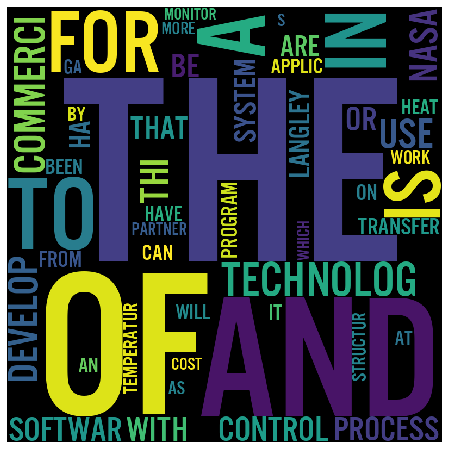

In [6]:
# Tag Clouds
N = 50
top_stems = get_top_stems(stemmed_dict, N)
plot_wordcloud(top_stems)

/tmp/ipykernel_58520/3924120663.py:47: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 1)


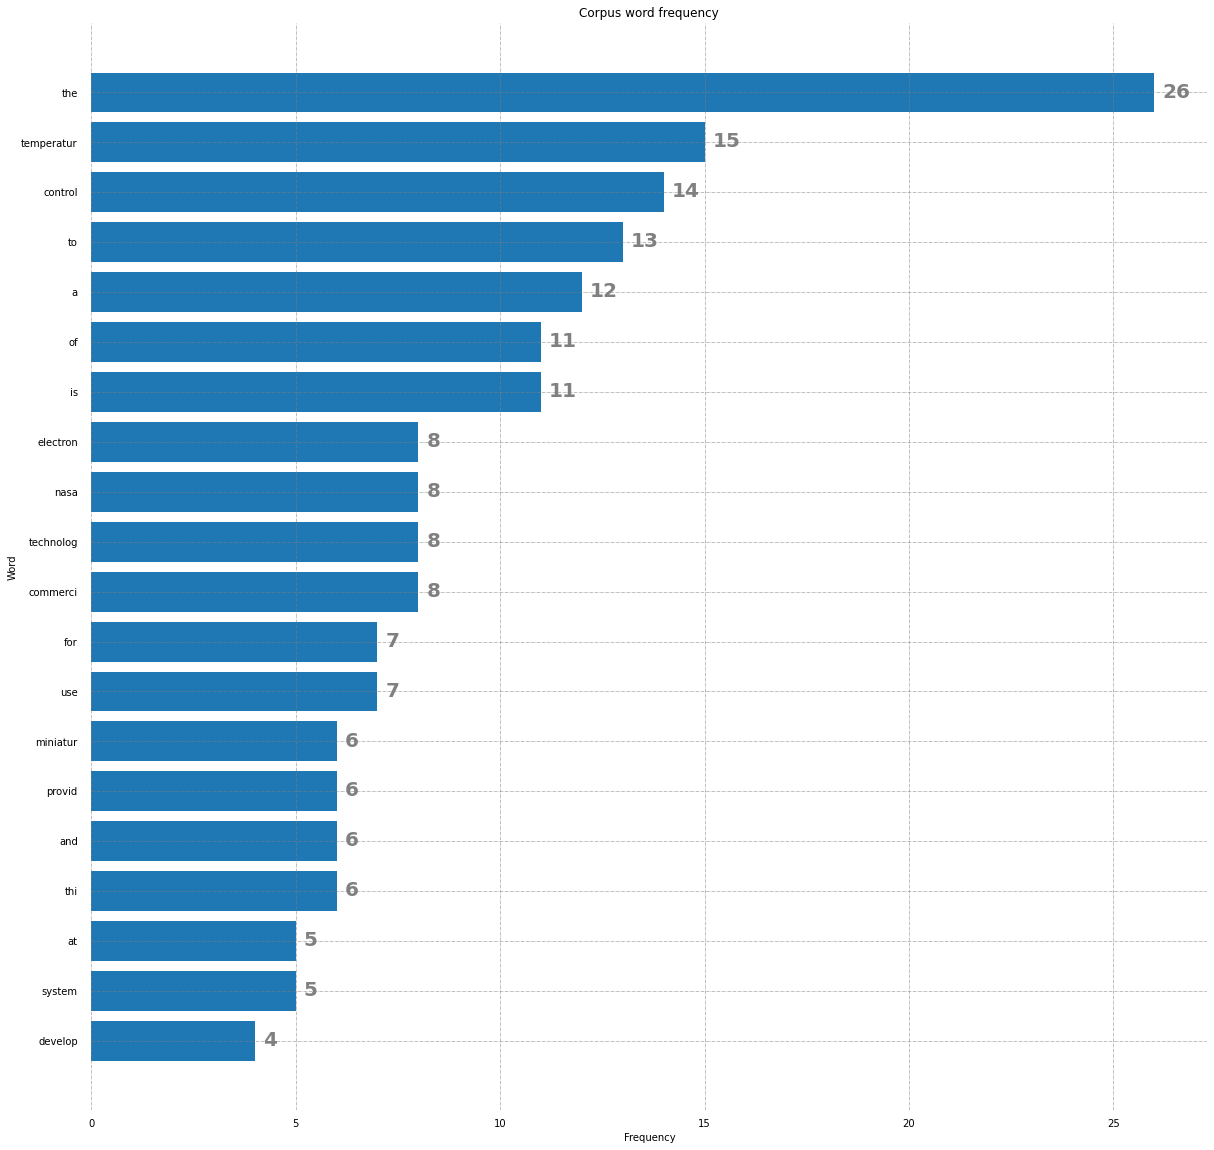

In [7]:
# Term frequency distribution plot in first document
N = 20
stemmed_dict, stemmed_text = stemmer([tokenized_text[0]])
top_stems = get_top_stems(stemmed_dict, N)
plot_tf_dist(top_stems)

## Task 3

In [8]:
def get_terms_per_doc(tokenized_text: list):
    terms_per_doc = [set(doc) for doc in tokenized_text]
    return terms_per_doc

def get_terms(tokenized_text: list):
    terms = set()
    for doc in tokenized_text:
        for token in doc:
            terms.add(token)
    return list(terms)

# Term Frequency
def get_tf_dict(tokenized_text: list, text_file_names: list, stemming=False):
    tf = {}
    if stemming:
        ps = PorterStemmer()
        for i, doc in enumerate(tokenized_text):
            freq_dict = {}
            for token in doc:
                root = ps.stem(token)
                if root in freq_dict:
                    freq_dict[root] += 1
                else:
                    freq_dict[root] = 1
            file = text_file_names[i]
            tf[file] = freq_dict
    else:
        for i, doc in enumerate(tokenized_text):
            freq_dict = {}
            for token in doc:
                if token in freq_dict:
                    freq_dict[token] += 1
                else:
                    freq_dict[token] = 1
            file = text_file_names[i]
            tf[file] = freq_dict
    return tf

def get_tf_matrix(tf_dict: dict):    
    tf_matrix = pd.DataFrame.from_dict(tf_dict)
    tf_matrix = tf_matrix.fillna(0)
    tf_matrix = tf_matrix / tf_matrix.max()
    return tf_matrix

# Inverse Document Frequency
def get_idf_dict(tokenized_text: list, text_file_names: list, stemming=False):
    if stemming:
        _, tokenized_text = stemmer(tokenized_text)
    terms_per_doc = get_terms_per_doc(tokenized_text)
    terms = get_terms(tokenized_text)
    idf = {}
    N = len(text_file_names)
    for term in terms:
        count = 0
        for doc in terms_per_doc:
            if term in doc:
                count += 1
        idf[term] = np.log(N / count)
    return idf

# Term Frequency - Inverse Document Frequency
def get_tf_idf_matrix(tf_matrix: pd.DataFrame, idf_dict: dict):
    tfidf_matrix = tf_matrix.copy()
    for term in tfidf_matrix.index:
        tfidf_matrix.loc[term] = tfidf_matrix.loc[term] * idf_dict[term]
    return tfidf_matrix

# Stem Analysis
def get_top_stems_per_doc(df: pd.DataFrame, n: int):
    docs = df.columns.values.tolist()
    terms = df.index.values.tolist()
    top_stems = []
    for i in range(len(docs)):
        doc_values = zip(terms, df.iloc[:, i])
        doc_values = sorted(doc_values, key = lambda x : x[1], reverse=True)[:n]
        series = pd.Series([x[1] for x in doc_values], index=[x[0] for x in doc_values])
        top_stems.append(series)
        
    top_stems_by_doc = pd.DataFrame(top_stems)
    top_stems_by_doc = top_stems_by_doc.T
    top_stems_by_doc = top_stems_by_doc.fillna(0)
    top_stems_by_doc.columns = docs
    return top_stems, top_stems_by_doc

def get_avg_stem(df: pd.DataFrame, columnName: str, n=0):
    avg_stem = df.mean(axis=1).to_frame()
    avg_stem.columns = [columnName]
    avg_stem = avg_stem.sort_values(by=[columnName], ascending=False)
    if n > 0:
        avg_stem = avg_stem[:n]
    return avg_stem

# Keyword Comparison
def keyword_comparison(directory: str):
    key_files = glob.glob(f"{directory}/*.key")
    text = get_text(key_files)
    tokenized_text = tokenization(text)
    _, stemmed_text = stemmer(tokenized_text)
    key_files = [Path(file).stem + '.key' for file in key_files]
    stemmed_keyword_dict = {doc: keywords for doc, keywords in zip(key_files, stemmed_text)}
    return stemmed_keyword_dict

def display_keyword_comparison(stemmed_keyword_dict: dict, top_stems: list, top_stems_by_doc: pd.DataFrame, title: str, idx=-1, doc=None):
    if doc is None:
        doc = top_stems_by_doc.columns[idx]
    if idx < 0:
        idx = top_stems_by_doc.columns.tolist().index(doc)
    print(title)
    print(f"Document: {doc}\n")
    print("Top stems in document")
    print(top_stems[idx])
    print("\n\nKeywords")
    doc = Path(doc).stem + '.key'
    print(f"{stemmed_keyword_dict[doc]}\n\n")

def display_stem_comparison(top_stems: list, top_stems_by_doc: pd.DataFrame, title: str, idxs=[], docs=[]):
    if docs == []:
        docs = [top_stems_by_doc.columns[idx] for idx in idxs]
    if idxs == []:
        idxs = [top_stems_by_doc.columns.tolist().index(doc) for doc in docs]
    print(title)
    for idx, doc in zip(idxs, docs): 
        print(f"Document: {doc}\n")
        print("Top stems in document")
        print(top_stems[idx])
        print("\n")
    print("\n")

def plot_stem_frequency(top_stems: list, n: int):
    data = {}
    for doc in top_stems:
        stems = doc.index.values.tolist()
        for stem in stems:
            if stem not in data:
                data[stem] = 0
            data[stem] += 1

    keys = list(data.keys())
    values = list(data.values())
    sorted_value_index = np.argsort(values)[::-1][:n]
    data = {keys[i]: values[i] for i in sorted_value_index}
    data = dict(stems=data.keys(), frequency=data.values())
    
    df = pd.DataFrame.from_dict(data)
    plt.figure(figsize=(20, 10))
    sns.barplot(x="stems", y="frequency", data=df)
    plt.xticks(rotation=90)
    plt.show()

In [9]:
# Compute term frequency matrix and tf-idf matrix for all documents
directory = "./nasa"
text_files = get_text_files(directory, shuffle=False)
text_file_names = [text_file.split('/')[-1] for text_file in text_files]
text = get_text(text_files)
tokenized_text = tokenization(text)

In [10]:
tf_dict = get_tf_dict(tokenized_text, text_file_names, stemming=True)
tf_matrix = get_tf_matrix(tf_dict)
print(tf_matrix)

            ins15795.txt  emt15895.txt  ins20495.txt  inf12795.txt  \
miniatur        0.230769      0.000000      0.000000        0.0000   
electron        0.307692      0.000000      0.000000        0.0000   
temperatur      0.576923      0.000000      0.045455        0.0000   
control         0.538462      0.466667      0.000000        0.0000   
a               0.461538      0.533333      1.000000        0.4375   
...                  ...           ...           ...           ...   
reignit         0.000000      0.000000      0.000000        0.0000   
petroleum       0.000000      0.000000      0.000000        0.0000   
restart         0.000000      0.000000      0.000000        0.0000   
render          0.000000      0.000000      0.000000        0.0000   
preced          0.000000      0.000000      0.000000        0.0000   

            sbr17695.txt  ins04195.txt  emt10195.txt  emt20895.txt  \
miniatur        0.000000      0.000000      0.000000      0.000000   
electron        0.0

In [11]:
idf_dict = get_idf_dict(tokenized_text, text_file_names, stemming=True)
tfidf_matrix = get_tf_idf_matrix(tf_matrix, idf_dict)
print(tfidf_matrix)

            ins15795.txt  emt15895.txt  ins20495.txt  inf12795.txt  \
miniatur        0.692965      0.000000      0.000000       0.00000   
electron        0.387656      0.000000      0.000000       0.00000   
temperatur      0.712608      0.000000      0.056145       0.00000   
control         0.526867      0.456618      0.000000       0.00000   
a               0.006594      0.007619      0.014286       0.00625   
...                  ...           ...           ...           ...   
reignit         0.000000      0.000000      0.000000       0.00000   
petroleum       0.000000      0.000000      0.000000       0.00000   
restart         0.000000      0.000000      0.000000       0.00000   
render          0.000000      0.000000      0.000000       0.00000   
preced          0.000000      0.000000      0.000000       0.00000   

            sbr17695.txt  ins04195.txt  emt10195.txt  emt20895.txt  \
miniatur        0.000000      0.000000      0.000000      0.000000   
electron        0.0

In [12]:
# Top p stems for each document using term frequency matrix
p = 20
tf_top_stems, tf_top_stems_by_doc = get_top_stems_per_doc(tf_matrix, p)
# print(tf_top_stems_by_doc)

# Comparing top p stems across all documents using term frequency matrix
avg_tf_stem = get_avg_stem(tf_matrix, "Average_tf", p)
print(avg_tf_stem)

           Average_tf
the          0.944105
and          0.551805
of           0.531477
to           0.476259
a            0.323051
for          0.317165
in           0.310914
technolog    0.287116
commerci     0.267557
is           0.249443
nasa         0.217646
develop      0.203604
thi          0.192120
use          0.164404
with         0.140328
system       0.137992
are          0.135444
or           0.124542
program      0.123140
be           0.120366


In [13]:
# Top p stems for each document using tf-idf matrix
p = 20
tfidf_top_stems, tfidf_top_stems_by_doc = get_top_stems_per_doc(tfidf_matrix, p)
# print(tfidf_top_stems_by_doc)

# Comparing top p stems across all documents using tf-idf matrix
avg_tfidf_stem = get_avg_stem(tfidf_matrix, "Average_tfidf", p)
print(avg_tfidf_stem)

            Average_tfidf
flow             0.073483
temperatur       0.068657
structur         0.065143
analysi          0.063593
control          0.062581
softwar          0.061214
o                0.061105
optic            0.059138
nois             0.055957
materi           0.055469
sensor           0.054854
data             0.054332
composit         0.051901
model            0.051587
measur           0.051312
imag             0.050806
comput           0.050424
system           0.048800
high             0.047201
ga               0.047019


In [14]:
# Comparing with keywords
stemmed_keyword_dict = keyword_comparison(directory)
display_keyword_comparison(stemmed_keyword_dict, tf_top_stems, tf_top_stems_by_doc, "Keyword Comparison Using Term Frequency", idx=0)
display_keyword_comparison(stemmed_keyword_dict, tfidf_top_stems, tfidf_top_stems_by_doc, "Keyword Comparison Using TF-IDF", idx=0)

Keyword Comparison Using Term Frequency
Document: ins15795.txt

Top stems in document
the           1.000000
temperatur    0.576923
control       0.538462
to            0.500000
a             0.461538
of            0.423077
is            0.423077
electron      0.307692
nasa          0.307692
technolog     0.307692
commerci      0.307692
for           0.269231
use           0.269231
miniatur      0.230769
provid        0.230769
and           0.230769
thi           0.230769
at            0.192308
system        0.192308
develop       0.153846
dtype: float64


Keywords
['temperatur', 'control', 'transduc', 'surfac', 'mount', 'compon', 'set', 'point', 'resist', 'temperatur', 'detector', 'rtd']


Keyword Comparison Using TF-IDF
Document: ins15795.txt

Top stems in document
temperatur    0.712608
miniatur      0.692965
control       0.526867
electron      0.387656
heater        0.380674
mm            0.364269
f             0.344725
dc            0.327355
turn          0.296165
deg           0

In [15]:
# Comparing top stems across specific documents
display_stem_comparison(tf_top_stems, tf_top_stems_by_doc, "Term Frequency Comparison", idxs=[0, 1])
display_stem_comparison(tfidf_top_stems, tfidf_top_stems_by_doc, "TF-IDF Comparison", idxs=[0, 1])

Term Frequency Comparison
Document: ins15795.txt

Top stems in document
the           1.000000
temperatur    0.576923
control       0.538462
to            0.500000
a             0.461538
of            0.423077
is            0.423077
electron      0.307692
nasa          0.307692
technolog     0.307692
commerci      0.307692
for           0.269231
use           0.269231
miniatur      0.230769
provid        0.230769
and           0.230769
thi           0.230769
at            0.192308
system        0.192308
develop       0.153846
dtype: float64


Document: emt15895.txt

Top stems in document
of          1.000000
and         0.933333
the         0.933333
vibrat      0.800000
for         0.733333
softwar     0.733333
a           0.533333
era         0.533333
control     0.466667
mode        0.466667
nasa        0.400000
to          0.400000
structur    0.400000
commerci    0.333333
use         0.333333
space       0.333333
develop     0.266667
at          0.266667
in          0.266667
is    

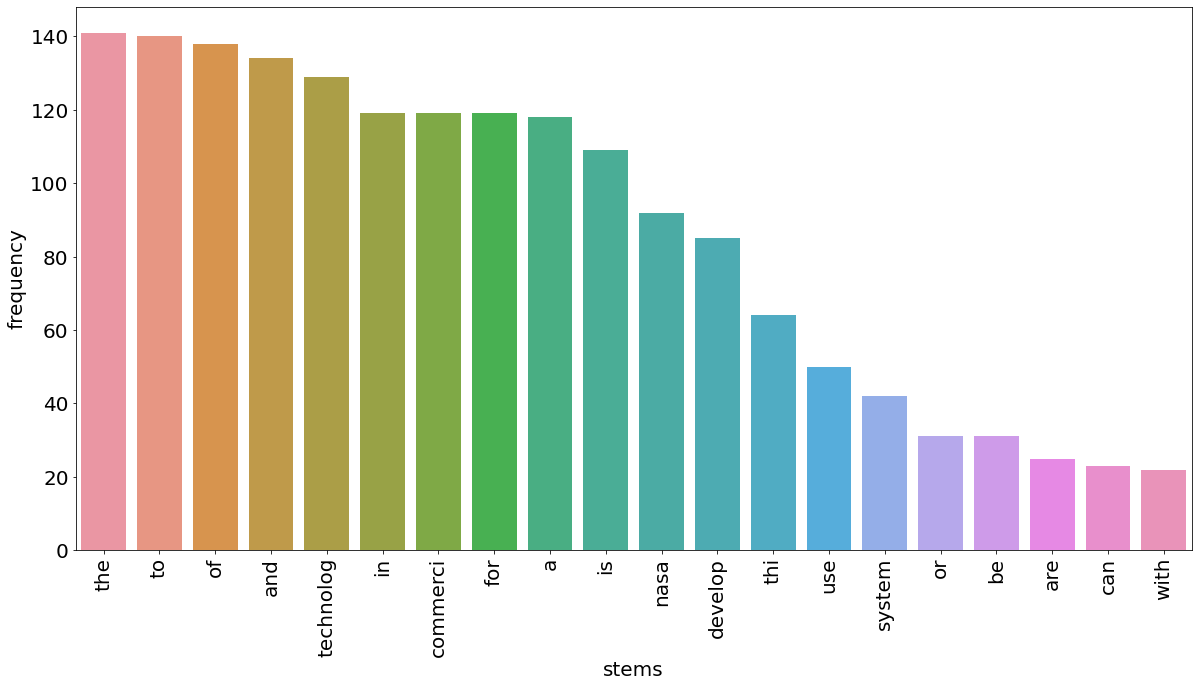

In [16]:
plot_stem_frequency(tf_top_stems, p)

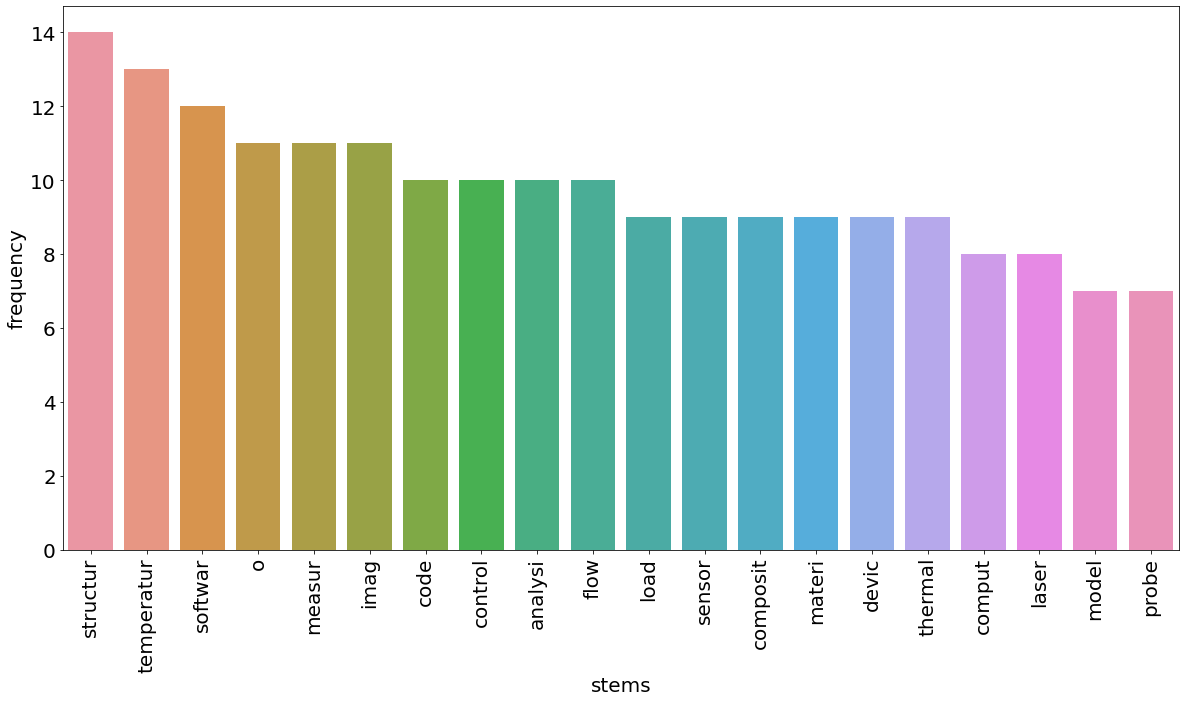

In [17]:
plot_stem_frequency(tfidf_top_stems, p)

## Task 4

In [18]:
# Boolean and vector models based on top p stems
def complete_vocabulary(df: pd.DataFrame, top_stems_by_doc: pd.DataFrame):
    top_stems_doc = top_stems_by_doc.copy()
    vocab = df.index.values.tolist()
    current_vocab = set(top_stems_doc.index.values.tolist())
    for term in vocab:
        if term not in current_vocab:
            top_stems_doc.loc[term] = 0.0
    return top_stems_doc

def boolean_model(df: pd.DataFrame, top_stems_by_doc: pd.DataFrame):
    top_stems_doc = complete_vocabulary(df, top_stems_by_doc)
    docs = top_stems_doc.columns.values.tolist()
    terms = top_stems_doc.index.values.tolist()
    boolean_matrix = pd.DataFrame(0, index=terms, columns=docs)
    for doc in docs:
        for term in terms:
            if top_stems_doc.loc[term, doc] > 0:
                boolean_matrix.loc[term, doc] = 1
    return boolean_matrix

def vector_model(df: pd.DataFrame, top_stems_by_doc: pd.DataFrame):
    vector_matrix = complete_vocabulary(df, top_stems_by_doc)
    return vector_matrix

# Query vectorization
def get_query(directory: str, N=1):
    text_files = get_text_files(directory, N=N, shuffle=True)
    text = get_text(text_files)
    text_files = [Path(file).stem + '.txt' for file in text_files]
    query = ""
    for t in text:
        start = random.randint(0, len(t) // 2)
        end = random.randint(start, len(t))
        query += t[start:end]
    query = tokenization(query)
    return query, text_files

def get_query_vector(query: list, df: pd.DataFrame):
    query_vector = pd.Series(0, index=df.index.values.tolist())
    for term in query:
        if term in query_vector.index:
            query_vector.loc[term] += 1
    query_vector = query_vector / query_vector.max()
    return query_vector

# Retrieval and ranking
def retrieval(query_vector: pd.Series, df: pd.DataFrame):
    docs = df.columns.values.tolist()
    terms = df.index.values.tolist()
    retrieval_list = []
    for doc in docs:
        doc_vector = df[doc]
        retrieval_list.append((doc, query_vector.dot(doc_vector)))
    retrieval_list = sorted(retrieval_list, key=lambda x: x[1], reverse=True)
    return retrieval_list

def display_result(query: list, docs: list, retrieval_list: list):
    print(f"Query\n{query}\n")
    print(f"Documents from which query is generated\n{docs}\n")
    print(f"Ranked List\n{retrieval_list}\n")
    for i, (doc, score) in enumerate(retrieval_list):
        if doc in docs:
            print(f"Document {doc} with score {score} is at rank {i + 1}")

def test_model(query: list, docs: list, model: pd.DataFrame, display=True):
    query_vector = get_query_vector(query, model)
    retrieval_list = retrieval(query_vector, model)
    if display:
        display_result(query, docs, retrieval_list)
        return retrieval_list
    result = {}
    for i, (doc, score) in enumerate(retrieval_list):
        if doc in docs:
            result[doc] = i + 1
    return result

In [19]:
# tf system based on top stems
tf_boolean_matrix = boolean_model(tf_matrix, tf_top_stems_by_doc)
tf_vector_matrix = vector_model(tf_matrix, tf_top_stems_by_doc)

# tf-idf system based on top stems
tfidf_boolean_matrix = boolean_model(tfidf_matrix, tfidf_top_stems_by_doc)
tfidf_vector_matrix = vector_model(tfidf_matrix, tfidf_top_stems_by_doc)

In [20]:
# Compare models using query
N = 2
directory = "./nasa"
query, docs = get_query(directory, N=N)

In [21]:
test_model(query, docs, tf_boolean_matrix)

Query
['rs', 'thereby', 'increasing', 'productivity', 'unique', 'tool', 'for', 'the', 'design', 'analysis', 'of', 'low', 'drag', 'laminar', 'flow', 'airfoils', 'invaluable', 'visualization', 'tool', 'to', 'learn', 'airfoil', 'boundary', 'layer', 'and', 'stability', 'analysis', 'multi', 'platform', 'based', 'both', 'pc', 's', 'and', 'workstations', 'written', 'in', 'motif', 'running', 'under', 'x', 'windows', 'increases', 'the', 'reliability', 'of', 'laminar', 'airfoil', 'design', 'significantly', 'provides', 'modularity', 'so', 'test', 'related', 'computer', 'codes', 'could', 'be', 'added', 'to', 'the', 'user', 'interface', 'provides', 'complete', 'bookkeeping', 'of', 'user', 'files', 'related', 'to', 'the', 'laminar', 'flow', 'analysis', 'naca', 'series', 'airfoil', 'generation', 'capabilities', 'integrated', 'within', 'the', 'graphic', 'user', 'interface', 'the', 'technology', 'the', 'quest', 'for', 'performance', 'fuel', 'efficiency', 'range', 'and', 'speed', 'in', 'the', 'current',

[('sbr15695.txt', 4.5769230769230775),
 ('emt04595.txt', 4.461538461538462),
 ('inf02895.txt', 4.423076923076923),
 ('eos00395.txt', 4.384615384615385),
 ('mip15495.txt', 4.307692307692308),
 ('inf21695.txt', 4.26923076923077),
 ('eos06795.txt', 4.26923076923077),
 ('ins20495.txt', 4.230769230769231),
 ('mip14195.txt', 4.230769230769231),
 ('eos19595.txt', 4.230769230769231),
 ('eos06895.txt', 4.230769230769231),
 ('emt14395.txt', 4.1923076923076925),
 ('emt13295.txt', 4.153846153846154),
 ('emt04795.txt', 4.153846153846154),
 ('emt13495.txt', 4.153846153846154),
 ('eos16095.txt', 4.115384615384616),
 ('inf12495.txt', 4.115384615384615),
 ('emt02495.txt', 4.115384615384615),
 ('ins04695.txt', 4.0769230769230775),
 ('inf11595.txt', 4.076923076923077),
 ('ins04195.txt', 4.038461538461538),
 ('emt14295.txt', 4.038461538461538),
 ('ins16495.txt', 4.038461538461538),
 ('ins20795.txt', 4.038461538461538),
 ('mat01095.txt', 4.038461538461538),
 ('emt11895.txt', 4.038461538461538),
 ('inf07395

In [22]:
test_model(query, docs, tf_vector_matrix)

Query
['rs', 'thereby', 'increasing', 'productivity', 'unique', 'tool', 'for', 'the', 'design', 'analysis', 'of', 'low', 'drag', 'laminar', 'flow', 'airfoils', 'invaluable', 'visualization', 'tool', 'to', 'learn', 'airfoil', 'boundary', 'layer', 'and', 'stability', 'analysis', 'multi', 'platform', 'based', 'both', 'pc', 's', 'and', 'workstations', 'written', 'in', 'motif', 'running', 'under', 'x', 'windows', 'increases', 'the', 'reliability', 'of', 'laminar', 'airfoil', 'design', 'significantly', 'provides', 'modularity', 'so', 'test', 'related', 'computer', 'codes', 'could', 'be', 'added', 'to', 'the', 'user', 'interface', 'provides', 'complete', 'bookkeeping', 'of', 'user', 'files', 'related', 'to', 'the', 'laminar', 'flow', 'analysis', 'naca', 'series', 'airfoil', 'generation', 'capabilities', 'integrated', 'within', 'the', 'graphic', 'user', 'interface', 'the', 'technology', 'the', 'quest', 'for', 'performance', 'fuel', 'efficiency', 'range', 'and', 'speed', 'in', 'the', 'current',

[('sbr15695.txt', 3.238866396761133),
 ('emt11895.txt', 2.976923076923077),
 ('inf21695.txt', 2.9069478908188584),
 ('ins16495.txt', 2.855769230769231),
 ('emt15895.txt', 2.8025641025641024),
 ('sbr21495.txt', 2.7875457875457874),
 ('emt14395.txt', 2.697435897435897),
 ('mat02095.txt', 2.674358974358974),
 ('str03295.txt', 2.6730769230769234),
 ('emt01995.txt', 2.6314102564102564),
 ('sbr17695.txt', 2.626602564102564),
 ('ins20495.txt', 2.590909090909091),
 ('emt13895.txt', 2.585664335664336),
 ('mip14895.txt', 2.5323076923076924),
 ('emt04995.txt', 2.5137362637362637),
 ('sbr01495.txt', 2.4983277591973243),
 ('mip15495.txt', 2.496655518394649),
 ('mat06495.txt', 2.4965034965034967),
 ('sbr12295.txt', 2.494301994301994),
 ('inf12795.txt', 2.487980769230769),
 ('mat14695.txt', 2.477732793522267),
 ('emt04795.txt', 2.4696356275303644),
 ('str02595.txt', 2.467032967032967),
 ('eos19595.txt', 2.457692307692308),
 ('mat18195.txt', 2.4571005917159763),
 ('inf21595.txt', 2.449038461538462),
 

In [23]:
test_model(query, docs, tfidf_boolean_matrix)

Query
['rs', 'thereby', 'increasing', 'productivity', 'unique', 'tool', 'for', 'the', 'design', 'analysis', 'of', 'low', 'drag', 'laminar', 'flow', 'airfoils', 'invaluable', 'visualization', 'tool', 'to', 'learn', 'airfoil', 'boundary', 'layer', 'and', 'stability', 'analysis', 'multi', 'platform', 'based', 'both', 'pc', 's', 'and', 'workstations', 'written', 'in', 'motif', 'running', 'under', 'x', 'windows', 'increases', 'the', 'reliability', 'of', 'laminar', 'airfoil', 'design', 'significantly', 'provides', 'modularity', 'so', 'test', 'related', 'computer', 'codes', 'could', 'be', 'added', 'to', 'the', 'user', 'interface', 'provides', 'complete', 'bookkeeping', 'of', 'user', 'files', 'related', 'to', 'the', 'laminar', 'flow', 'analysis', 'naca', 'series', 'airfoil', 'generation', 'capabilities', 'integrated', 'within', 'the', 'graphic', 'user', 'interface', 'the', 'technology', 'the', 'quest', 'for', 'performance', 'fuel', 'efficiency', 'range', 'and', 'speed', 'in', 'the', 'current',

[('sbr15695.txt', 1.153846153846154),
 ('mip14195.txt', 0.576923076923077),
 ('eos00395.txt', 0.5),
 ('mip15495.txt', 0.42307692307692313),
 ('emt04595.txt', 0.3846153846153846),
 ('emt11895.txt', 0.3846153846153846),
 ('inf21695.txt', 0.34615384615384615),
 ('emt04795.txt', 0.2692307692307693),
 ('emt10495.txt', 0.2692307692307693),
 ('emt14395.txt', 0.2692307692307693),
 ('eos07795.txt', 0.2692307692307693),
 ('inf18595.txt', 0.2692307692307693),
 ('eos06795.txt', 0.2692307692307693),
 ('sbr12195.txt', 0.23076923076923078),
 ('eos06695.txt', 0.23076923076923078),
 ('emt01995.txt', 0.23076923076923078),
 ('eos06895.txt', 0.23076923076923078),
 ('sbr17895.txt', 0.23076923076923078),
 ('eos11695.txt', 0.19230769230769232),
 ('emt04895.txt', 0.19230769230769232),
 ('emt13295.txt', 0.15384615384615385),
 ('str03295.txt', 0.15384615384615385),
 ('mip18495.txt', 0.15384615384615385),
 ('inf21595.txt', 0.15384615384615385),
 ('emt21795.txt', 0.15384615384615385),
 ('emt10695.txt', 0.15384615

In [24]:
test_model(query, docs, tfidf_vector_matrix)

Query
['rs', 'thereby', 'increasing', 'productivity', 'unique', 'tool', 'for', 'the', 'design', 'analysis', 'of', 'low', 'drag', 'laminar', 'flow', 'airfoils', 'invaluable', 'visualization', 'tool', 'to', 'learn', 'airfoil', 'boundary', 'layer', 'and', 'stability', 'analysis', 'multi', 'platform', 'based', 'both', 'pc', 's', 'and', 'workstations', 'written', 'in', 'motif', 'running', 'under', 'x', 'windows', 'increases', 'the', 'reliability', 'of', 'laminar', 'airfoil', 'design', 'significantly', 'provides', 'modularity', 'so', 'test', 'related', 'computer', 'codes', 'could', 'be', 'added', 'to', 'the', 'user', 'interface', 'provides', 'complete', 'bookkeeping', 'of', 'user', 'files', 'related', 'to', 'the', 'laminar', 'flow', 'analysis', 'naca', 'series', 'airfoil', 'generation', 'capabilities', 'integrated', 'within', 'the', 'graphic', 'user', 'interface', 'the', 'technology', 'the', 'quest', 'for', 'performance', 'fuel', 'efficiency', 'range', 'and', 'speed', 'in', 'the', 'current',

[('sbr15695.txt', 1.1881467189533947),
 ('mip14195.txt', 0.6089008019313038),
 ('eos07795.txt', 0.36707378761468334),
 ('emt11895.txt', 0.3061819381622429),
 ('mip15495.txt', 0.23869099558193074),
 ('eos06895.txt', 0.23808653980246353),
 ('emt04595.txt', 0.21956646865648421),
 ('eos06695.txt', 0.20407417697354016),
 ('sbr12195.txt', 0.10988609529344473),
 ('eos00395.txt', 0.10941645778445913),
 ('str03295.txt', 0.10824227418621768),
 ('eos06795.txt', 0.10651868080496968),
 ('inf21695.txt', 0.1056003954774338),
 ('emt14395.txt', 0.09776284453179579),
 ('emt04795.txt', 0.09386719219863737),
 ('emt01995.txt', 0.09337633901448944),
 ('emt10495.txt', 0.08380543109159007),
 ('emt04895.txt', 0.08047399559284711),
 ('inf21595.txt', 0.07878915822159645),
 ('ins16495.txt', 0.07349165233583049),
 ('mip18495.txt', 0.0734845690795486),
 ('emt21795.txt', 0.07025780226452498),
 ('inf18595.txt', 0.06827267835735899),
 ('emt05095.txt', 0.06761811534742034),
 ('ins20595.txt', 0.06461998224607006),
 ('sb

In [25]:
# Ranked results of all models using k queries
k = 3
N = 2
directory = "./nasa"
results = {}
for i in range(k):
    key = "query" + str(i + 1)
    query, docs = get_query(directory, N=N)
    results[key] = {"query": query, "docs": docs}
    results[key]["tf_boolean"] = test_model(query, docs, tf_boolean_matrix, display=False)
    results[key]["tf_vector"] = test_model(query, docs, tf_vector_matrix, display=False)
    results[key]["tfidf_boolean"] = test_model(query, docs, tfidf_boolean_matrix, display=False)
    results[key]["tfidf_vector"] = test_model(query, docs, tfidf_vector_matrix, display=False)
results_string = json.dumps(results, indent=4)
print(results_string)

{
    "query1": {
        "query": [
            "strophes",
            "due",
            "to",
            "mechanical",
            "and",
            "electronic",
            "failures",
            "medical",
            "security",
            "determine",
            "security",
            "of",
            "computer",
            "systems",
            "nuclear",
            "power",
            "control",
            "systems",
            "predict",
            "effects",
            "of",
            "hardware",
            "software",
            "failures",
            "transportation",
            "predict",
            "catastrophes",
            "due",
            "to",
            "mechanical",
            "and",
            "electronic",
            "failures",
            "communications",
            "predict",
            "catastrophes",
            "due",
            "to",
            "mechanical",
            "and",
            "electronic",
            "failu

## Task 5

In [26]:
def get_stopwords(path: str):
    with open(path, 'r') as f:
        stopwords = f.read().splitlines()
    return stopwords

def remove_stopwords(path: str, tokenized_text: list):
    stopwords = get_stopwords(path)
    tokenized_text = [[token for token in doc if token not in stopwords] for doc in tokenized_text]
    return tokenized_text

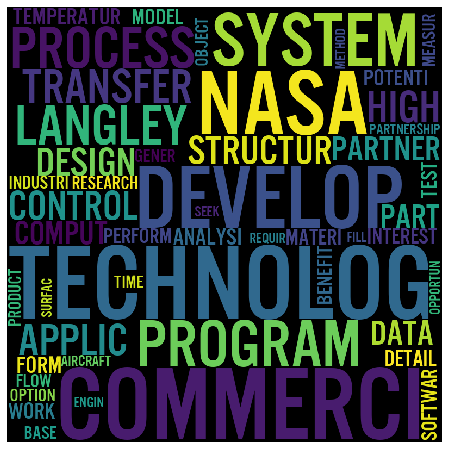

In [27]:
directory = "./nasa"
stop_words_path = "./english.stop"

# Preprocessing and stemming after removing stopwords
text_files = get_text_files(directory, shuffle=False)
text = get_text(text_files)
tokenized_text = tokenization(text)
tokenized_text = remove_stopwords(stop_words_path, tokenized_text)
stemmed_dict, tokenized_text = stemmer(tokenized_text)
text_files = [text_file.split('/')[-1] for text_file in text_files]

# Tag Clouds
N = 50
top_stems = get_top_stems(stemmed_dict, N)
plot_wordcloud(top_stems)

## Task 6

In [28]:
def model_comparison(res1: dict, res2: dict):
    for query in res1:
        data = res1[query]
        df = pd.DataFrame(columns=["model", "rank", "model_type"])
        short_names = {"tf_boolean": "tf_b", "tf_vector": "tf_v", "tfidf_boolean": "tfidf_b", "tfidf_vector": "tfidf_v"}
        for model in data:
            if model == "query" or model == "docs":
                continue
            for doc, rank in data[model].items():
                df.loc[len(df.index)] = [short_names[model], rank, "old"]
        data = res2[query]
        for model in data:
            if model == "query" or model == "docs":
                continue
            for doc, rank in data[model].items():
                df.loc[len(df.index)] = [short_names[model], rank, "new"]
        sns.set(style="ticks")
        sns.catplot(x = "model", y = "rank", hue = "model_type", data = df, kind="box")
        plt.grid()
        plt.show()

In [29]:
tf_dict = get_tf_dict(tokenized_text, text_file_names, stemming=True)
tf_matrix = get_tf_matrix(tf_dict)
print(tf_matrix)

            ins15795.txt  emt15895.txt  ins20495.txt  inf12795.txt  \
miniatur        0.400000      0.000000      0.000000          0.00   
electron        0.533333      0.000000      0.000000          0.00   
temperatur      1.000000      0.000000      0.071429          0.00   
control         0.933333      0.583333      0.000000          0.00   
develop         0.266667      0.333333      0.357143          0.25   
...                  ...           ...           ...           ...   
reignit         0.000000      0.000000      0.000000          0.00   
petroleum       0.000000      0.000000      0.000000          0.00   
restart         0.000000      0.000000      0.000000          0.00   
render          0.000000      0.000000      0.000000          0.00   
prece           0.000000      0.000000      0.000000          0.00   

            sbr17695.txt  ins04195.txt  emt10195.txt  emt20895.txt  \
miniatur        0.000000      0.000000         0.000           0.0   
electron        0.1

In [30]:
idf_dict = get_idf_dict(tokenized_text, text_file_names, stemming=True)
tfidf_matrix = get_tf_idf_matrix(tf_matrix, idf_dict)
print(tfidf_matrix)

            ins15795.txt  emt15895.txt  ins20495.txt  inf12795.txt  \
miniatur        1.201140      0.000000      0.000000           0.0   
electron        0.671936      0.000000      0.000000           0.0   
temperatur      1.235188      0.000000      0.088228           0.0   
control         0.913237      0.570773      0.000000           0.0   
develop         0.000000      0.000000      0.000000           0.0   
...                  ...           ...           ...           ...   
reignit         0.000000      0.000000      0.000000           0.0   
petroleum       0.000000      0.000000      0.000000           0.0   
restart         0.000000      0.000000      0.000000           0.0   
render          0.000000      0.000000      0.000000           0.0   
prece           0.000000      0.000000      0.000000           0.0   

            sbr17695.txt  ins04195.txt  emt10195.txt  emt20895.txt  \
miniatur        0.000000           0.0           0.0      0.000000   
electron        0.1

In [31]:
# Top p stems for each document using term frequency matrix
p = 20
tf_top_stems, tf_top_stems_by_doc = get_top_stems_per_doc(tf_matrix, p)
# print(tf_top_stems_by_doc)

# Comparing top p stems across all documents using term frequency matrix
avg_tf_stem = get_avg_stem(tf_matrix, "Average_tf", p)
print(avg_tf_stem)

           Average_tf
technolog    0.536330
commerci     0.510911
nasa         0.410537
develop      0.380893
system       0.246082
program      0.232606
process      0.182578
langley      0.166936
transfer     0.164288
high         0.142473
applic       0.135192
partner      0.123420
design       0.113292
control      0.111073
part         0.108410
structur     0.106743
comput       0.104932
form         0.099753
data         0.097744
potenti      0.097375


In [32]:
# Top p stems for each document using tf-idf matrix
p = 20
tfidf_top_stems, tfidf_top_stems_by_doc = get_top_stems_per_doc(tfidf_matrix, p)
# print(tfidf_top_stems_by_doc)

# Comparing top p stems across all documents using tf-idf matrix
avg_tfidf_stem = get_avg_stem(tfidf_matrix, "Average_tfidf", p)
print(avg_tfidf_stem)

            Average_tfidf
flow             0.125180
temperatur       0.118749
imag             0.111256
control          0.108682
structur         0.108550
softwar          0.105385
analysi          0.105241
measur           0.103427
model            0.101939
data             0.101335
comput           0.098786
sensor           0.097620
materi           0.097110
optic            0.095015
composit         0.089383
surfac           0.087325
system           0.087024
ga               0.086137
devic            0.085459
pressur          0.084926


In [33]:
# Comparing with keywords
stemmed_keyword_dict = keyword_comparison(directory)
display_keyword_comparison(stemmed_keyword_dict, tf_top_stems, tf_top_stems_by_doc, "Keyword Comparison Using Term Frequency", idx=0)
display_keyword_comparison(stemmed_keyword_dict, tfidf_top_stems, tfidf_top_stems_by_doc, "Keyword Comparison Using TF-IDF", idx=0)

Keyword Comparison Using Term Frequency
Document: ins15795.txt

Top stems in document
temperatur    1.000000
control       0.933333
electron      0.533333
nasa          0.533333
technolog     0.533333
commerci      0.533333
miniatur      0.400000
system        0.333333
develop       0.266667
langley       0.200000
monitor       0.200000
signal        0.200000
circuit       0.200000
mm            0.200000
point         0.200000
deg           0.200000
program       0.200000
environ       0.133333
transduc      0.133333
aircraft      0.133333
dtype: float64


Keywords
['temperatur', 'control', 'transduc', 'surfac', 'mount', 'compon', 'set', 'point', 'resist', 'temperatur', 'detector', 'rtd']


Keyword Comparison Using TF-IDF
Document: ins15795.txt

Top stems in document
temperatur    1.235188
miniatur      1.201140
control       0.913237
electron      0.671936
heater        0.659835
mm            0.631400
dc            0.567415
turn          0.513353
deg           0.476762
hz            0

In [34]:
# Comparing top stems across specific documents
display_stem_comparison(tf_top_stems, tf_top_stems_by_doc, "Term Frequency Comparison", idxs=[0, 1])
display_stem_comparison(tfidf_top_stems, tfidf_top_stems_by_doc, "TF-IDF Comparison", idxs=[0, 1])

Term Frequency Comparison
Document: ins15795.txt

Top stems in document
temperatur    1.000000
control       0.933333
electron      0.533333
nasa          0.533333
technolog     0.533333
commerci      0.533333
miniatur      0.400000
system        0.333333
develop       0.266667
langley       0.200000
monitor       0.200000
signal        0.200000
circuit       0.200000
mm            0.200000
point         0.200000
deg           0.200000
program       0.200000
environ       0.133333
transduc      0.133333
aircraft      0.133333
dtype: float64


Document: emt15895.txt

Top stems in document
vibrat       1.000000
softwar      0.916667
era          0.666667
control      0.583333
mode         0.583333
nasa         0.500000
structur     0.500000
commerci     0.416667
space        0.416667
develop      0.333333
modal        0.333333
analysi      0.333333
design       0.333333
engin        0.333333
activ        0.333333
version      0.333333
technolog    0.250000
user         0.250000
system   

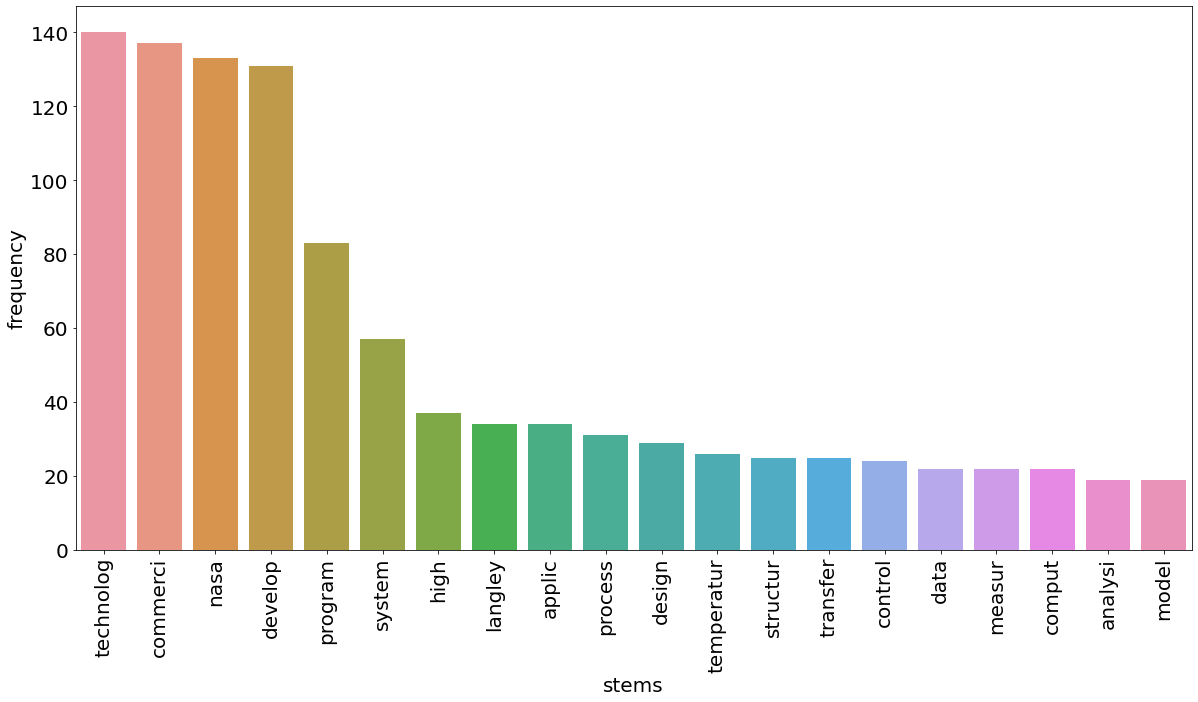

In [35]:
plot_stem_frequency(tf_top_stems, p)

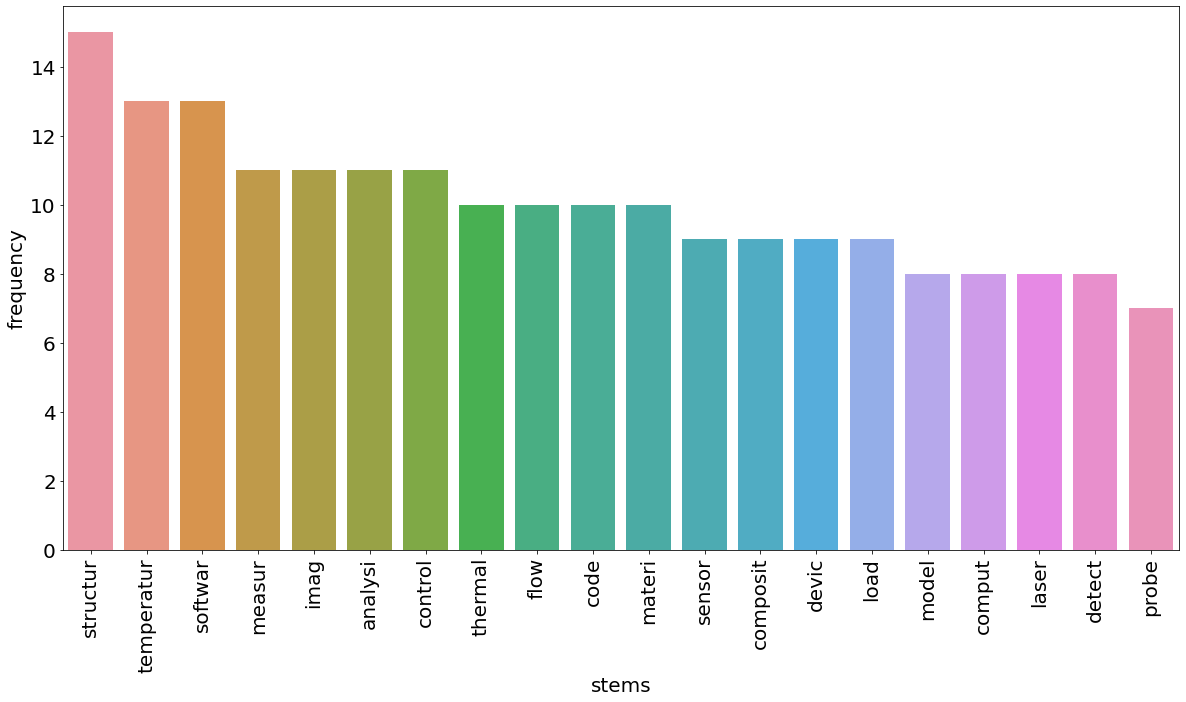

In [36]:
plot_stem_frequency(tfidf_top_stems, p)

In [37]:
# tf system based on top stems
new_tf_boolean_matrix = boolean_model(tf_matrix, tf_top_stems_by_doc)
new_tf_vector_matrix = vector_model(tf_matrix, tf_top_stems_by_doc)

# tf-idf system based on top stems
new_tfidf_boolean_matrix = boolean_model(tfidf_matrix, tfidf_top_stems_by_doc)
new_tfidf_vector_matrix = vector_model(tfidf_matrix, tfidf_top_stems_by_doc)

In [38]:
# Ranked results of all models using k queries
k = 3
N = 2
directory = "./nasa"
new_results = {}
for i in range(k):
    key = "query" + str(i + 1)
    query, docs = results[key]["query"], results[key]["docs"]
    new_results[key] = {"query": query, "docs": docs}
    new_results[key]["tf_boolean"] = test_model(query, docs, new_tf_boolean_matrix, display=False)
    new_results[key]["tf_vector"] = test_model(query, docs, new_tf_vector_matrix, display=False)
    new_results[key]["tfidf_boolean"] = test_model(query, docs, new_tfidf_boolean_matrix, display=False)
    new_results[key]["tfidf_vector"] = test_model(query, docs, new_tfidf_vector_matrix, display=False)
new_results_string = json.dumps(results, indent=4)
print(new_results_string)

{
    "query1": {
        "query": [
            "strophes",
            "due",
            "to",
            "mechanical",
            "and",
            "electronic",
            "failures",
            "medical",
            "security",
            "determine",
            "security",
            "of",
            "computer",
            "systems",
            "nuclear",
            "power",
            "control",
            "systems",
            "predict",
            "effects",
            "of",
            "hardware",
            "software",
            "failures",
            "transportation",
            "predict",
            "catastrophes",
            "due",
            "to",
            "mechanical",
            "and",
            "electronic",
            "failures",
            "communications",
            "predict",
            "catastrophes",
            "due",
            "to",
            "mechanical",
            "and",
            "electronic",
            "failu

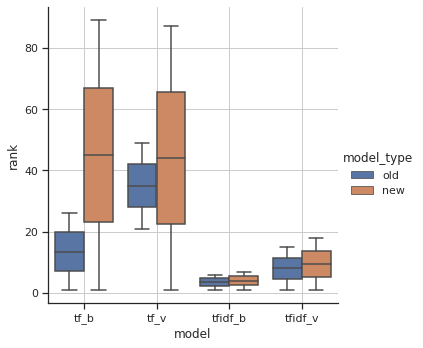

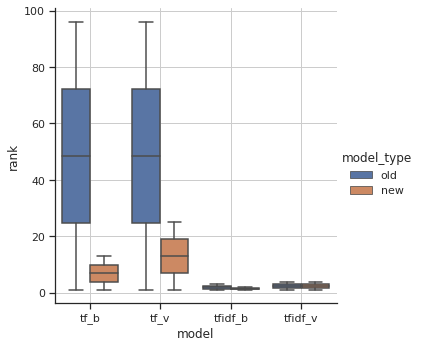

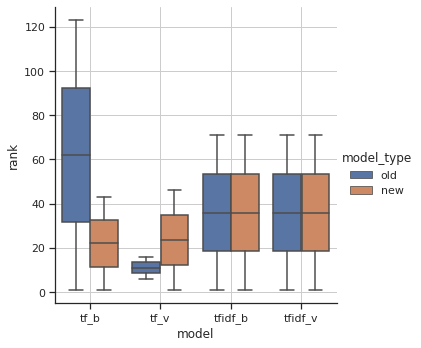

In [39]:
model_comparison(results, new_results)

## Task 7

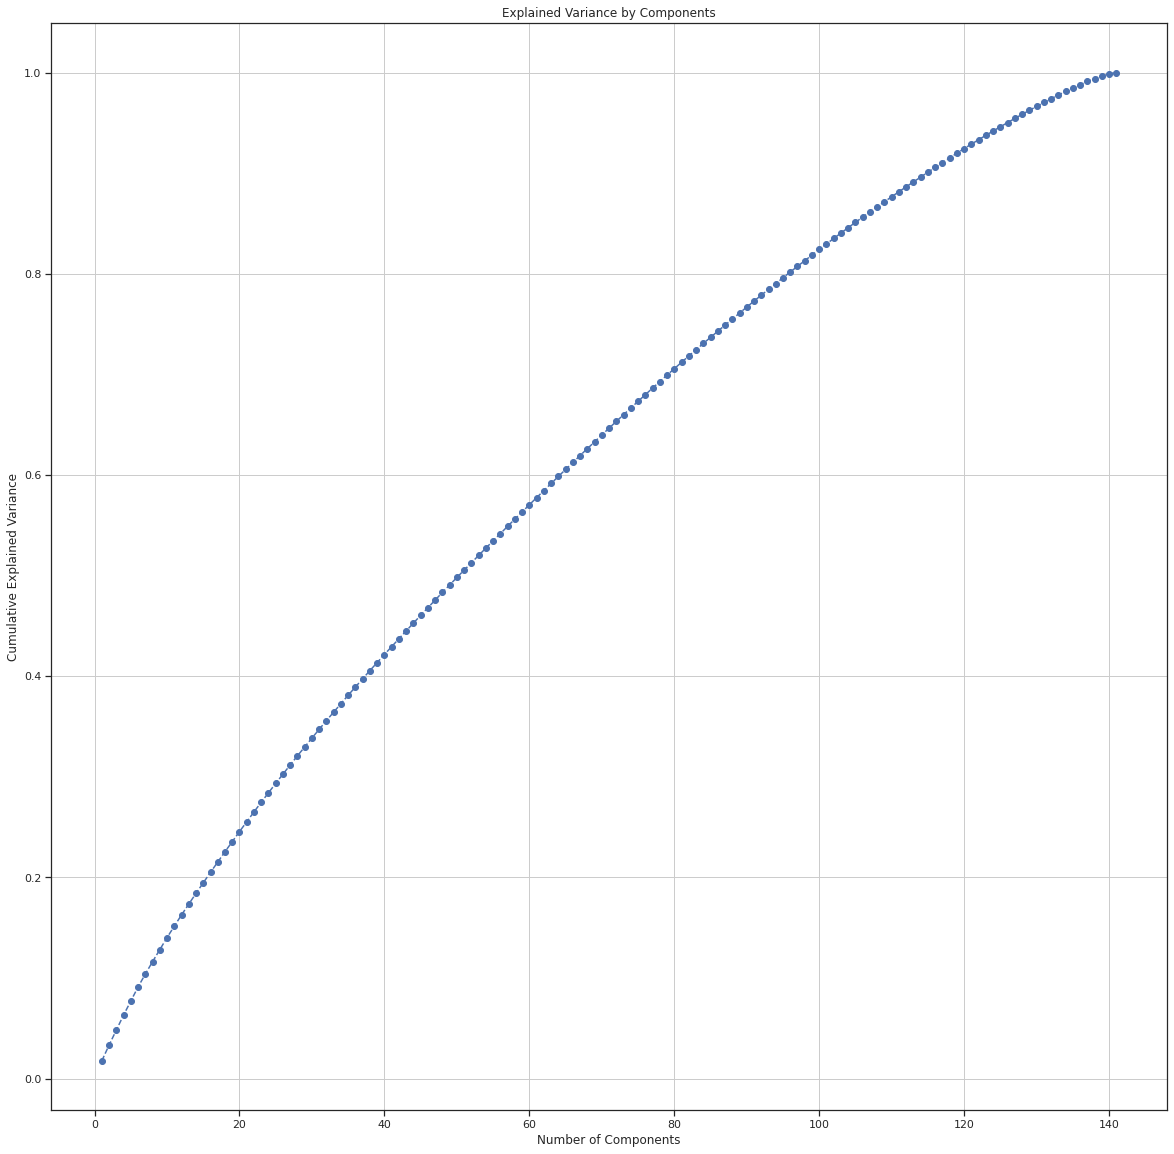

In [40]:
df = tfidf_vector_matrix.copy()
scaler = StandardScaler()
df_std = scaler.fit_transform(df)
pca = PCA()
pca.fit(df_std)
# print(pca.explained_variance_ratio_)
plt.figure(figsize=(20, 20))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()

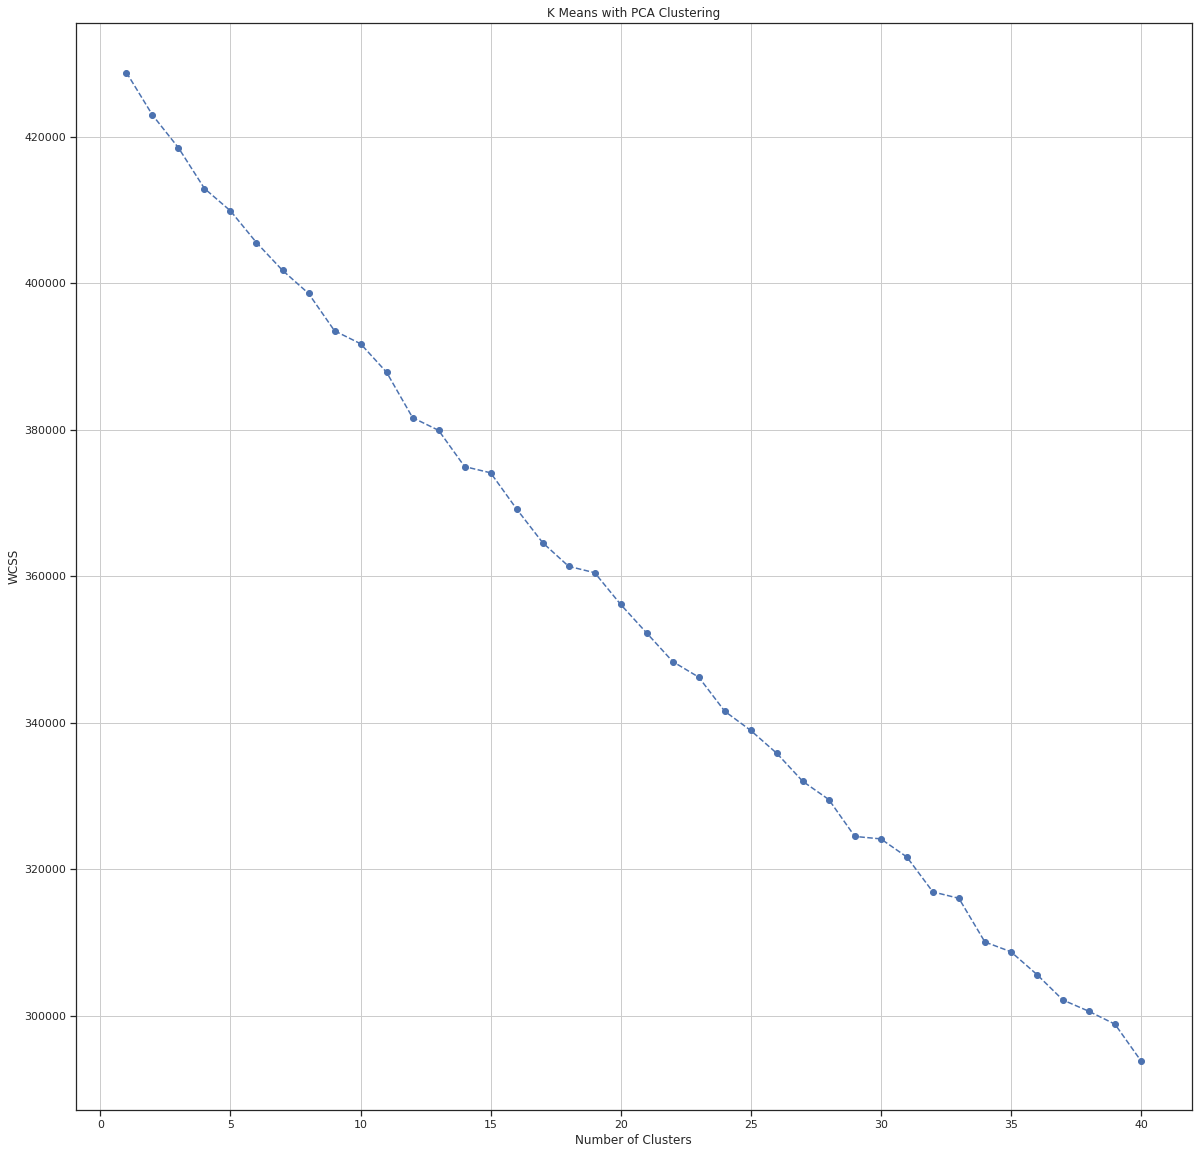

In [41]:
pca = PCA(n_components=90)
pca.fit(df_std)
scores_pca = pca.transform(df_std)

# Within Cluster Sum of Squares
wcss = []
for i in range(1, 41):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scores_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(20, 20))
plt.plot(range(1, 41), wcss, marker='o', linestyle='--')
plt.title('K Means with PCA Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()

In [42]:
kmeans_pca = KMeans(n_clusters=15, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)
df_kmeans_pca = pd.concat([df.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_kmeans_pca.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
df_kmeans_pca['Segment K-Means PCA'] = kmeans_pca.labels_
df_kmeans_pca.head()

,ins15795.txt,emt15895.txt,ins20495.txt,inf12795.txt,sbr17695.txt,ins04195.txt,emt10195.txt,emt20895.txt,sbr16395.txt,mip14895.txt,...,81,82,83,84,85,86,Component 1,Component 2,Component 3,Segment K-Means PCA
0,0.712608,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.345853,...,3.336970,2.071005,0.444319,-3.406365,-2.462457,0.566957,-2.661448,-0.994769,-0.746910,0
1,0.692965,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,7.762256,4.235711,1.047206,-3.387790,2.964722,-3.170617,-1.921094,1.594624,-1.849614,0
2,0.526867,0.456618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.979391,3.637900,-0.095940,1.190345,0.480228,-1.357924,2.323238,-2.120274,-1.051792,0
3,0.387656,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,2.553606,3.688050,-0.471041,-2.198511,1.559585,0.740212,-2.004247,-0.028966,-0.947287,0
4,0.380674,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,2.836902,3.037059,-0.139251,-1.921646,0.309162,0.108849,-1.124764,0.709774,-0.903306,0


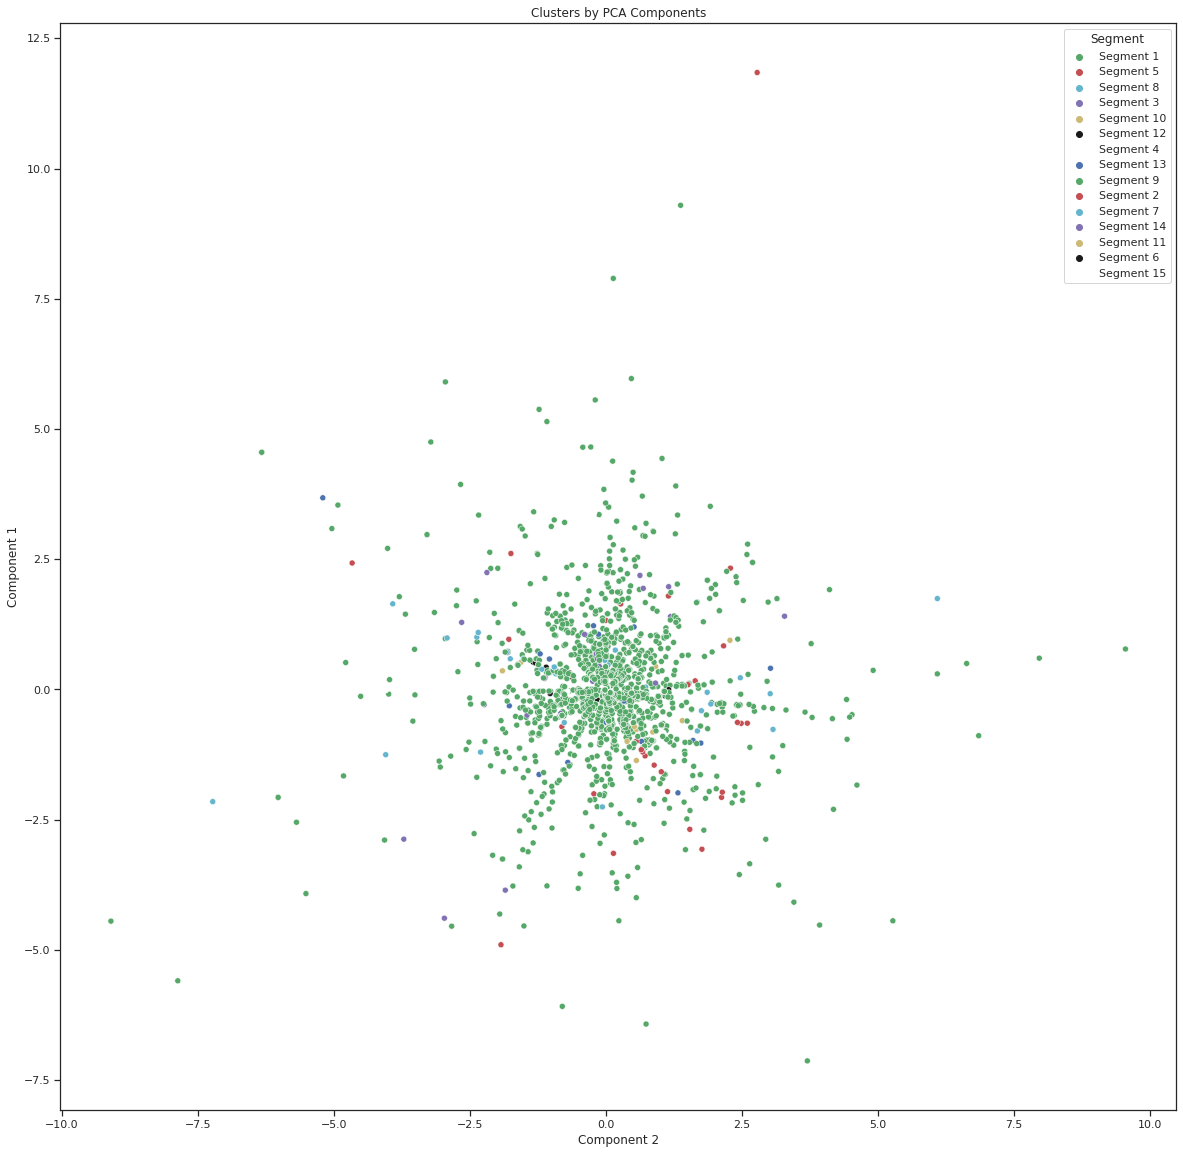

In [43]:
df_kmeans_pca["Segment"] = df_kmeans_pca["Segment K-Means PCA"].map({0: 'Segment 1', 1: 'Segment 2', 2: 'Segment 3', 3: 'Segment 4', 4: 'Segment 5', 5: 'Segment 6', 6: 'Segment 7', 7: 'Segment 8', 8: 'Segment 9', 9: 'Segment 10', 10: 'Segment 11', 11: 'Segment 12', 12: 'Segment 13', 13: 'Segment 14', 14: 'Segment 15'})
x_axis = df_kmeans_pca["Component 2"]
y_axis = df_kmeans_pca["Component 1"]
plt.figure(figsize=(20, 20))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_kmeans_pca["Segment"], palette=['g', 'r', 'c', 'm', 'y', 'k', 'w', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])
plt.title('Clusters by PCA Components')
plt.show()

## Practical Requirements

In [44]:
def complete_boolean_model(df: pd.DataFrame):
    docs = df.columns.values.tolist()
    terms = df.index.values.tolist()
    boolean_matrix = pd.DataFrame(0, index=terms, columns=docs)
    for doc in docs:
        for term in terms:
            if df.loc[term, doc] > 0:
                boolean_matrix.loc[term, doc] = 1
    return boolean_matrix

def createTermDocumentMatrix(directory: str, stop_words_path: str, boolean=False, stemming=False):
    text_files = get_text_files(directory, shuffle=False)
    text = get_text(text_files)
    tokenized_text = tokenization(text)
    tokenized_text = remove_stopwords(stop_words_path, tokenized_text)
    if stemming:
        _, tokenized_text = stemmer(tokenized_text)
    text_files = [text_file.split('/')[-1] for text_file in text_files]
    tf_dict = get_tf_dict(tokenized_text, text_files, stemming=stemming)
    tf_matrix = get_tf_matrix(tf_dict)
    idf_dict = get_idf_dict(tokenized_text, text_file_names, stemming=stemming)
    tfidf_matrix = get_tf_idf_matrix(tf_matrix, idf_dict)
    if boolean:
        tf_matrix = complete_boolean_model(tf_matrix)
        tfidf_matrix = complete_boolean_model(tfidf_matrix)
    return tf_matrix, tfidf_matrix, idf_dict

def queryBooleanRepresentation(query: list, vocabulary: list):
    query_terms = set(query)
    query_vector = {}
    for term in vocabulary:
        if term in query_terms:
            query_vector[term] = 1
        else:
            query_vector[term] = 0
    return pd.Series(query_vector)

def queryVectorRepresentation(query: list, idf_dict: dict):
    query_dict = {}
    for term in query:
        if term not in query_dict:
            query_dict[term] = 1
        else:
            query_dict[term] += 1
            
    query_vector = {}
    for term in idf_dict:
        if term in query_dict:
            query_vector[term] = query_dict[term] * idf_dict[term]
        else:
            query_vector[term] = 0
    return pd.Series(query_vector)

# Query can be the boolean or vector representation of the query
def compQuery(query: pd.Series, docs: list, model: pd.DataFrame, display=True, N=0):
    retrieval_list = retrieval(query, model)
    if N > 0:
        retrieval_list = retrieval_list[:N]
    if display:
        display_result(query, docs, retrieval_list)
        return retrieval_list
    result = {}
    for i, (doc, score) in enumerate(retrieval_list):
        if doc in docs:
            result[doc] = i + 1
    return result

In [45]:
directory = "./nasa"
stop_words_path = "./english.stop"
tf_boolean_matrix, tfidf_boolean_matrix, _ = createTermDocumentMatrix(directory, stop_words_path, boolean=True, stemming=True)
tf_vector_matrix, tfidf_vector_matrix, idf_dict = createTermDocumentMatrix(directory, stop_words_path, boolean=False, stemming=True)
print(tf_vector_matrix)

            ins15795.txt  emt15895.txt  ins20495.txt  inf12795.txt  \
miniatur        0.400000      0.000000      0.000000          0.00   
electron        0.533333      0.000000      0.000000          0.00   
temperatur      1.000000      0.000000      0.071429          0.00   
control         0.933333      0.583333      0.000000          0.00   
develop         0.266667      0.333333      0.357143          0.25   
...                  ...           ...           ...           ...   
reignit         0.000000      0.000000      0.000000          0.00   
petroleum       0.000000      0.000000      0.000000          0.00   
restart         0.000000      0.000000      0.000000          0.00   
render          0.000000      0.000000      0.000000          0.00   
prece           0.000000      0.000000      0.000000          0.00   

            sbr17695.txt  ins04195.txt  emt10195.txt  emt20895.txt  \
miniatur        0.000000      0.000000         0.000           0.0   
electron        0.1

In [46]:
query, docs = get_query(directory, N=50)
vocabulary = tf_boolean_matrix.index.values.tolist()
query_boolean = queryBooleanRepresentation(query, vocabulary)
query_vector = queryVectorRepresentation(query, idf_dict)

# Number of ranked documents retrieved
N = 10

In [47]:
compQuery(query_boolean, docs, tf_boolean_matrix, N=N)

Query
miniatur      0
electron      0
temperatur    0
control       1
develop       1
             ..
reignit       0
petroleum     0
restart       0
render        0
prece         0
Length: 3733, dtype: int64

Documents from which query is generated
['mat02095.txt', 'emt02695.txt', 'emt17495.txt', 'mat17295.txt', 'mip09795.txt', 'ins05395.txt', 'eos19595.txt', 'mat01095.txt', 'mip19395.txt', 'emt14295.txt', 'emt11895.txt', 'emt01995.txt', 'mip15495.txt', 'str03295.txt', 'sbr17695.txt', 'ins05295.txt', 'sbr12295.txt', 'emt05095.txt', 'mip14195.txt', 'ins05895.txt', 'inf144b95.txt', 'sbr21395.txt', 'ins04095.txt', 'ins01795.txt', 'eos19995.txt', 'ins07595.txt', 'eos06695.txt', 'ins18795.txt', 'str10895.txt', 'eos11695.txt', 'inf11495.txt', 'mat09995.txt', 'sbr19195.txt', 'eos03595.txt', 'str01895.txt', 'sbr06195.txt', 'ins20795.txt', 'mip12595.txt', 'ins20495.txt', 'emt14395.txt', 'emt05995.txt', 'inf21695.txt', 'emt10495.txt', 'mip09195.txt', 'sbr06295.txt', 'emt10695.txt', 'inf19695.tx

[('ins20495.txt', 83),
 ('sbr01395.txt', 83),
 ('emt10495.txt', 82),
 ('mat02095.txt', 79),
 ('str10895.txt', 78),
 ('ins13995.txt', 72),
 ('sbr06295.txt', 72),
 ('inf11595.txt', 71),
 ('mat06395.txt', 71),
 ('mat17295.txt', 71)]

In [48]:
compQuery(query_vector, docs, tf_vector_matrix, N=N)

Query
ghz         0.000000
hit         0.000000
copper      3.562466
raid        0.000000
avoid       0.000000
              ...   
pot         0.000000
surround    0.000000
nickel      0.000000
fuzzi       0.000000
mil         0.000000
Length: 3733, dtype: float64

Documents from which query is generated
['mat02095.txt', 'emt02695.txt', 'emt17495.txt', 'mat17295.txt', 'mip09795.txt', 'ins05395.txt', 'eos19595.txt', 'mat01095.txt', 'mip19395.txt', 'emt14295.txt', 'emt11895.txt', 'emt01995.txt', 'mip15495.txt', 'str03295.txt', 'sbr17695.txt', 'ins05295.txt', 'sbr12295.txt', 'emt05095.txt', 'mip14195.txt', 'ins05895.txt', 'inf144b95.txt', 'sbr21395.txt', 'ins04095.txt', 'ins01795.txt', 'eos19995.txt', 'ins07595.txt', 'eos06695.txt', 'ins18795.txt', 'str10895.txt', 'eos11695.txt', 'inf11495.txt', 'mat09995.txt', 'sbr19195.txt', 'eos03595.txt', 'str01895.txt', 'sbr06195.txt', 'ins20795.txt', 'mip12595.txt', 'ins20495.txt', 'emt14395.txt', 'emt05995.txt', 'inf21695.txt', 'emt10495.txt', 'mi

[('str01895.txt', 180.45587338531078),
 ('sbr21395.txt', 151.85297747264698),
 ('emt17495.txt', 144.56228000466282),
 ('emt14295.txt', 135.35017891181144),
 ('sbr06295.txt', 132.9388150857071),
 ('ins20495.txt', 132.18656209209067),
 ('sbr12295.txt', 126.17141957197879),
 ('sbr19195.txt', 112.60649892152266),
 ('sbr17695.txt', 108.80896335896708),
 ('mip14895.txt', 105.00860859450913)]

In [49]:
compQuery(query_vector, docs, tfidf_boolean_matrix, N=N)

Query
ghz         0.000000
hit         0.000000
copper      3.562466
raid        0.000000
avoid       0.000000
              ...   
pot         0.000000
surround    0.000000
nickel      0.000000
fuzzi       0.000000
mil         0.000000
Length: 3733, dtype: float64

Documents from which query is generated
['mat02095.txt', 'emt02695.txt', 'emt17495.txt', 'mat17295.txt', 'mip09795.txt', 'ins05395.txt', 'eos19595.txt', 'mat01095.txt', 'mip19395.txt', 'emt14295.txt', 'emt11895.txt', 'emt01995.txt', 'mip15495.txt', 'str03295.txt', 'sbr17695.txt', 'ins05295.txt', 'sbr12295.txt', 'emt05095.txt', 'mip14195.txt', 'ins05895.txt', 'inf144b95.txt', 'sbr21395.txt', 'ins04095.txt', 'ins01795.txt', 'eos19995.txt', 'ins07595.txt', 'eos06695.txt', 'ins18795.txt', 'str10895.txt', 'eos11695.txt', 'inf11495.txt', 'mat09995.txt', 'sbr19195.txt', 'eos03595.txt', 'str01895.txt', 'sbr06195.txt', 'ins20795.txt', 'mip12595.txt', 'ins20495.txt', 'emt14395.txt', 'emt05995.txt', 'inf21695.txt', 'emt10495.txt', 'mi

[('ins20495.txt', 583.843752619088),
 ('str01895.txt', 576.2520201198517),
 ('emt17495.txt', 569.1907011232594),
 ('sbr12195.txt', 539.5875516464764),
 ('sbr06295.txt', 534.0633992426133),
 ('sbr01395.txt', 507.84501140566294),
 ('sbr06195.txt', 503.84930806009214),
 ('emt10495.txt', 503.5852317225251),
 ('mat09995.txt', 488.8853786594457),
 ('sbr12295.txt', 480.5203006613873)]

In [50]:
compQuery(query_vector, docs, tfidf_vector_matrix, N=N)

Query
ghz         0.000000
hit         0.000000
copper      3.562466
raid        0.000000
avoid       0.000000
              ...   
pot         0.000000
surround    0.000000
nickel      0.000000
fuzzi       0.000000
mil         0.000000
Length: 3733, dtype: float64

Documents from which query is generated
['mat02095.txt', 'emt02695.txt', 'emt17495.txt', 'mat17295.txt', 'mip09795.txt', 'ins05395.txt', 'eos19595.txt', 'mat01095.txt', 'mip19395.txt', 'emt14295.txt', 'emt11895.txt', 'emt01995.txt', 'mip15495.txt', 'str03295.txt', 'sbr17695.txt', 'ins05295.txt', 'sbr12295.txt', 'emt05095.txt', 'mip14195.txt', 'ins05895.txt', 'inf144b95.txt', 'sbr21395.txt', 'ins04095.txt', 'ins01795.txt', 'eos19995.txt', 'ins07595.txt', 'eos06695.txt', 'ins18795.txt', 'str10895.txt', 'eos11695.txt', 'inf11495.txt', 'mat09995.txt', 'sbr19195.txt', 'eos03595.txt', 'str01895.txt', 'sbr06195.txt', 'ins20795.txt', 'mip12595.txt', 'ins20495.txt', 'emt14395.txt', 'emt05995.txt', 'inf21695.txt', 'emt10495.txt', 'mi

[('str01895.txt', 570.3546439387806),
 ('ins20495.txt', 406.2787116111383),
 ('emt14295.txt', 396.67408920441846),
 ('sbr21395.txt', 395.3545618790035),
 ('mip14895.txt', 383.93494128109097),
 ('emt17495.txt', 359.5312441234215),
 ('sbr06295.txt', 355.5365396815907),
 ('mat17295.txt', 292.4822214959074),
 ('sbr12295.txt', 253.51455422294447),
 ('mip19395.txt', 249.2696061556889)]